In [1]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score,accuracy_score
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from collections import deque, defaultdict
from imblearn.over_sampling import SMOTE
import matplotlib.ticker as mticker
from warnings import filterwarnings
from xgboost import XGBClassifier
from scipy.special import softmax
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from keras import backend as K
from typing import Callable
import tensorflow as tf
from sklearn import svm
from typing import List
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import pickle
import random
import keras
import copy
import json
import os
import gc

sns.set(rc = {'figure.figsize':(22,12)}, style="whitegrid")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/data'
code_path = '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/codes'
results_path = '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results'
feature_selection_results = '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/feature_selection_results'
feature_selection_results_evolving = '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/feature_selection_results_evolving'

In [5]:
def save_object(obj, filename,path):
    """
    _ INPUT (obj) THE OBJECT WE NEED SAVW IT (filename) THE NAME OF OBJECT
    """
    filename = os.path.join(path,filename)
    with open(filename+".pkl", 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
    outp.close()
def load_object(filename,path):
    """
    _ INPUT THE NAME OF OBJECT WE NEED LOAD IT
    """
    filename = os.path.join(path,filename)
    with open(filename+".pkl", 'rb') as outp:
        loaded_object = pickle.load(outp)
    outp.close()
    return loaded_object

In [6]:
def plot_results(save_path,metric_name, methods_name, results, colors, step=1):
    plt.figure(figsize=(15, 5))
    plt.title(metric_name)
    for k, result in enumerate(results):
        x = [i for i, x in enumerate(results[k]) if i % step == 0]
        y = [x for i, x in enumerate(results[k]) if i % step == 0]
        plt.plot(x, y, color=colors[k], label=methods_name[k])
        plt.scatter(x, y, color=colors[k], s=20)  # Add dots to the plot

    plt.legend(loc="best")
    plt.xlabel('Chunk number')
    plt.ylabel('Results per Chunk')

    # Format x-axis ticks as integers
    plt.xticks(rotation=90)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(step))
    plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter(useOffset=False, useMathText=True))

    plt.savefig(os.path.join(save_path, metric_name))
    plt.savefig(os.path.join(save_path, metric_name+'.svg'), format='svg')
    plt.show()

In [7]:
# data_name = ['kddcup99','ISCX2012','CSE-CIC2018','CICIDS2017','7recurrentDrift', 'blip', 'incrementalDrift','7gradualDrift', '7suddenDrift']
# methods_name = ['Softmax <=> ALC','Average <=> AC','Single Agent <=> OA-OT','Random Forest <=> IM','Voting']
# colors = ['r', 'g', 'b', 'm','y'] # , 'c'
# metric_names = ['f1_score','recall_score','precision_score','accuracy_score']

# load_path = os.path.join(feature_selection_results,data_name[0])
# softmax_results = load_object("softmax_results",load_path)
# average_results = load_object("average_results",load_path)
# single_agent_results = load_object("single_agent_results",load_path)
# random_forest_results = load_object("random_forest_results",load_path)
# voting_results = load_object("voting_results",load_path)

In [9]:
# for d_name in data_name:
#   load_path = os.path.join(feature_selection_results,d_name)
#   save_path = os.path.join(os.path.join(feature_selection_results,'Images'),d_name)
#   os.makedirs(save_path, exist_ok=True)
#   print("===================== dataset : {} ======================".format(d_name))
#   for i,metric_name in enumerate(list(softmax_results.keys())[:-1]):
#     plot_results(save_path,metric_names[i]+" without evolving"+" for "+d_name, methods_name, [softmax_results[metric_name],average_results[metric_name],single_agent_results[metric_name],random_forest_results[metric_name],voting_results[metric_name]], colors, step=1)

In [10]:
data_name = ['kddcup99','ISCX2012','CSE-CIC2018','CICIDS2017','7recurrentDrift', 'blip', 'incrementalDrift','7gradualDrift', '7suddenDrift']
methods_name = ['Softmax <=> ALC','Average <=> AC','Single Agent <=> OA-OT','Random Forest <=> IM','Voting']
colors = ['r', 'g', 'b', 'm','y'] # , 'c'
metric_names = ['f1_score','recall_score','precision_score','accuracy_score']

load_path = os.path.join(feature_selection_results_evolving,data_name[0])
softmax_results = load_object("softmax_results",load_path)
average_results = load_object("average_results",load_path)
single_agent_results = load_object("single_agent_results",load_path)
random_forest_results = load_object("random_forest_results",load_path)
voting_results = load_object("voting_results",load_path)

===================== dataset : kddcup99 ======================


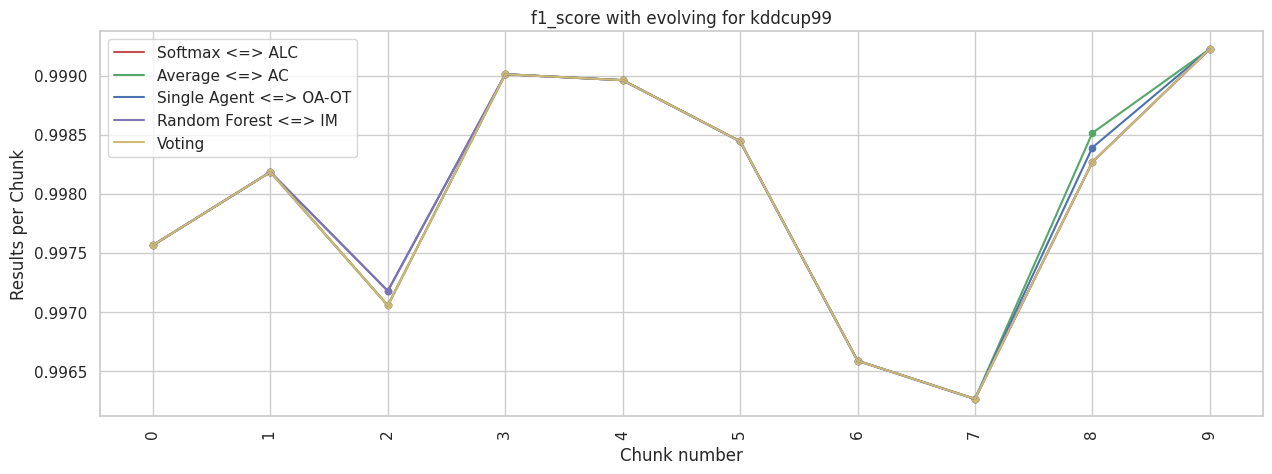

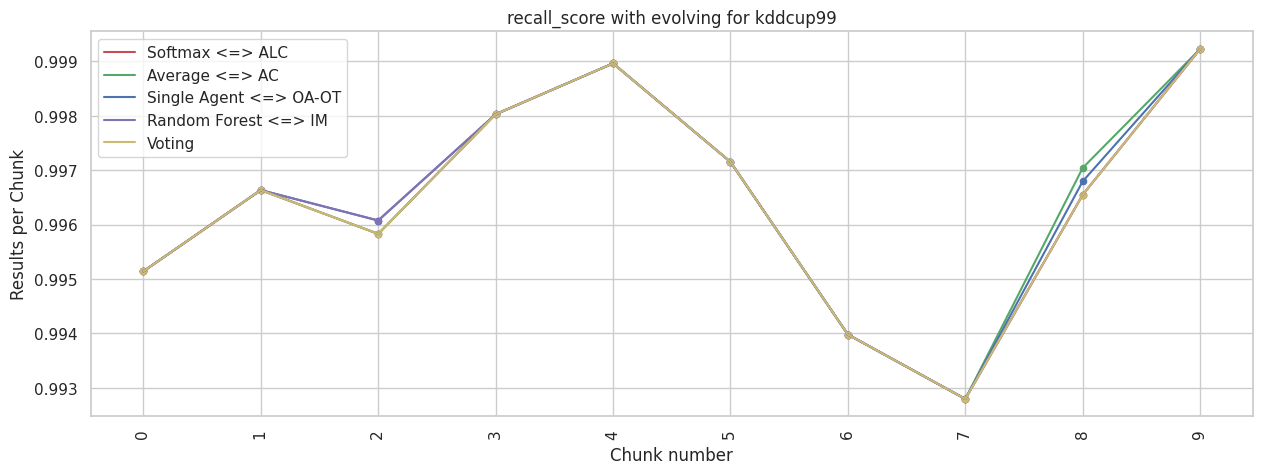

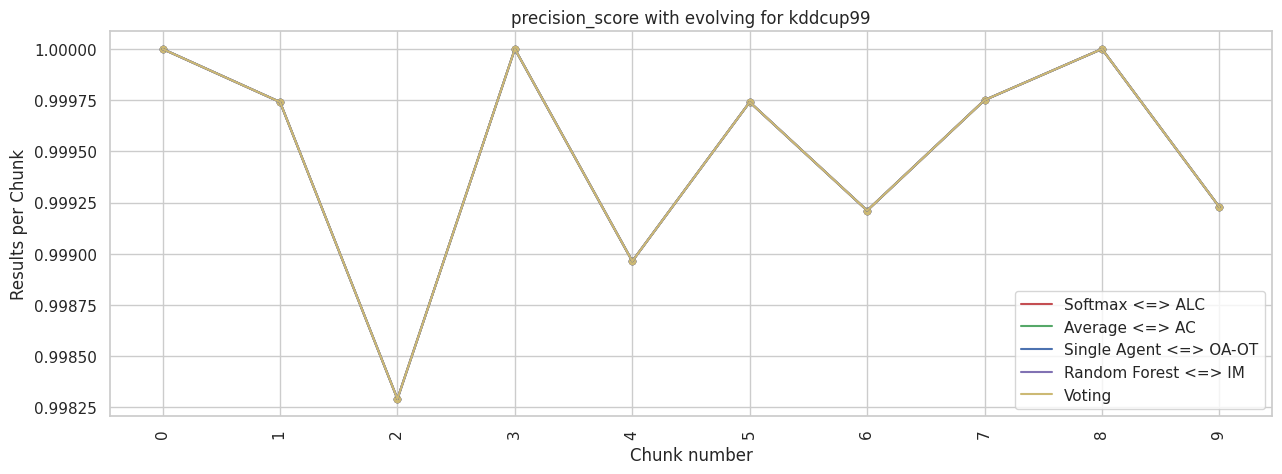

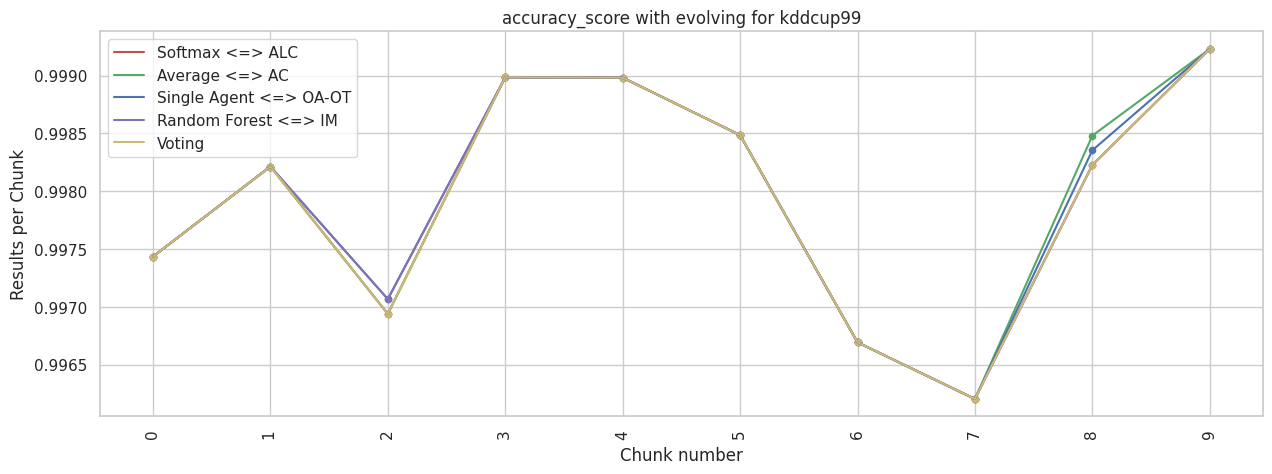

===================== dataset : ISCX2012 ======================


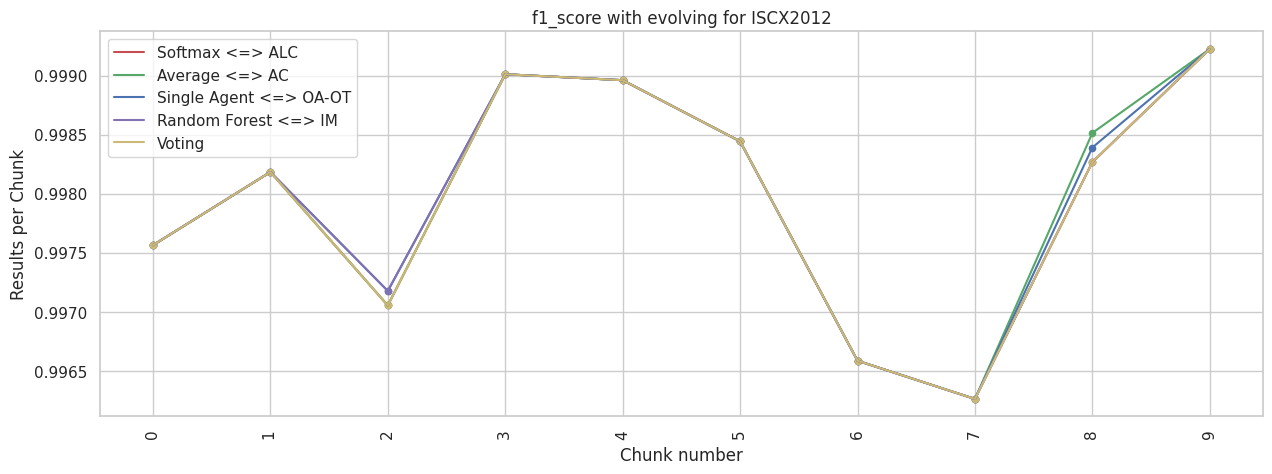

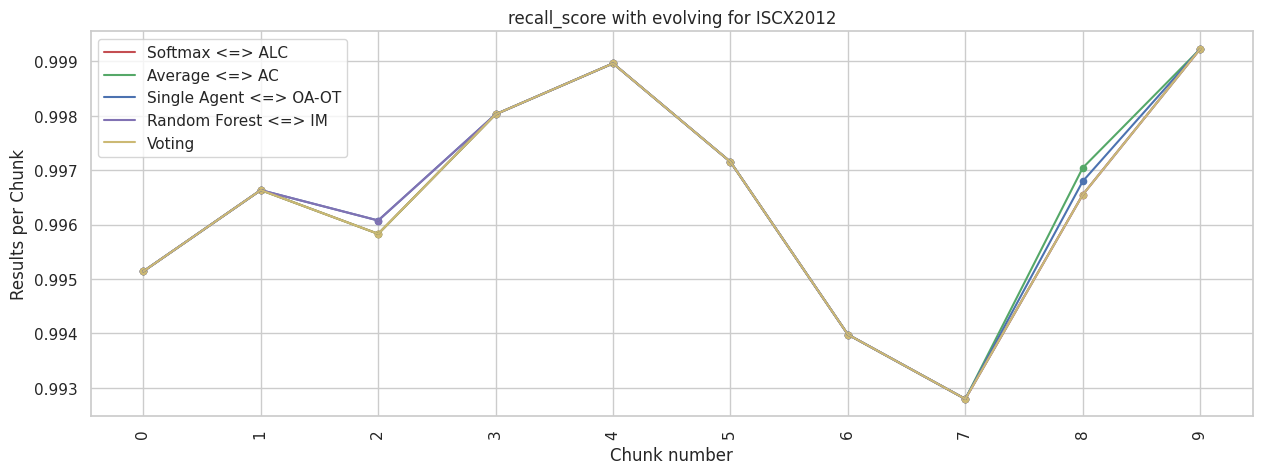

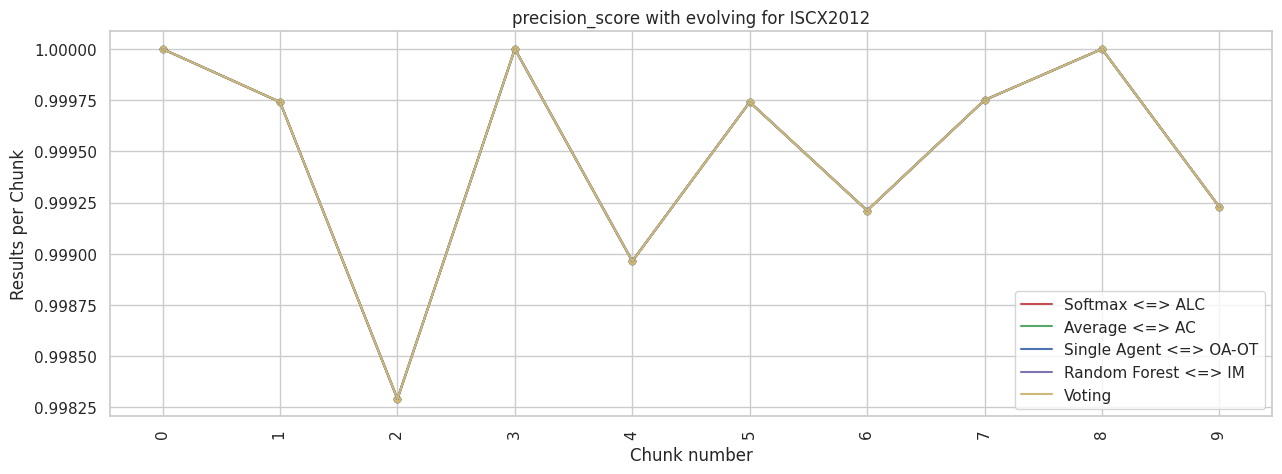

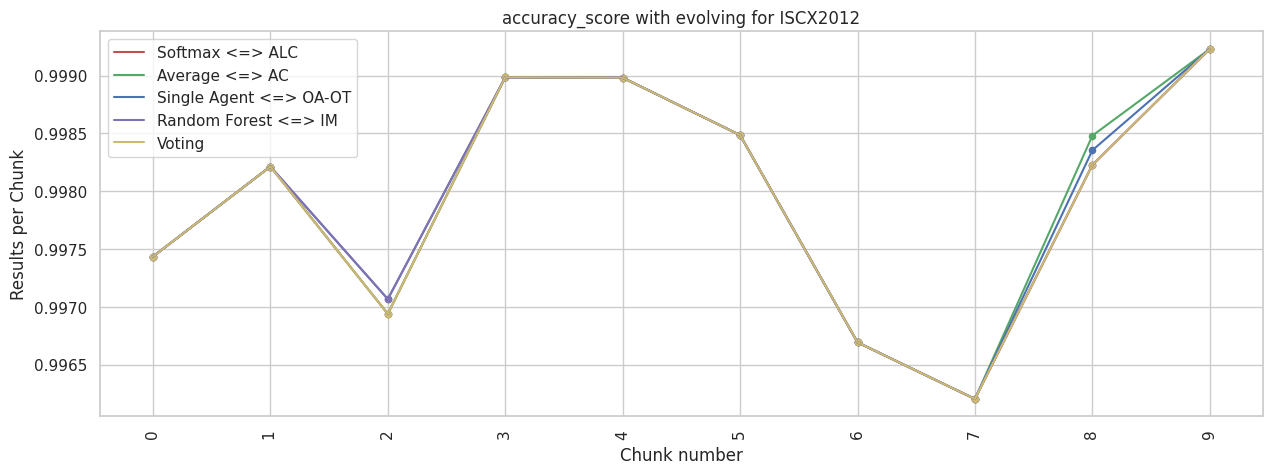

===================== dataset : CSE-CIC2018 ======================


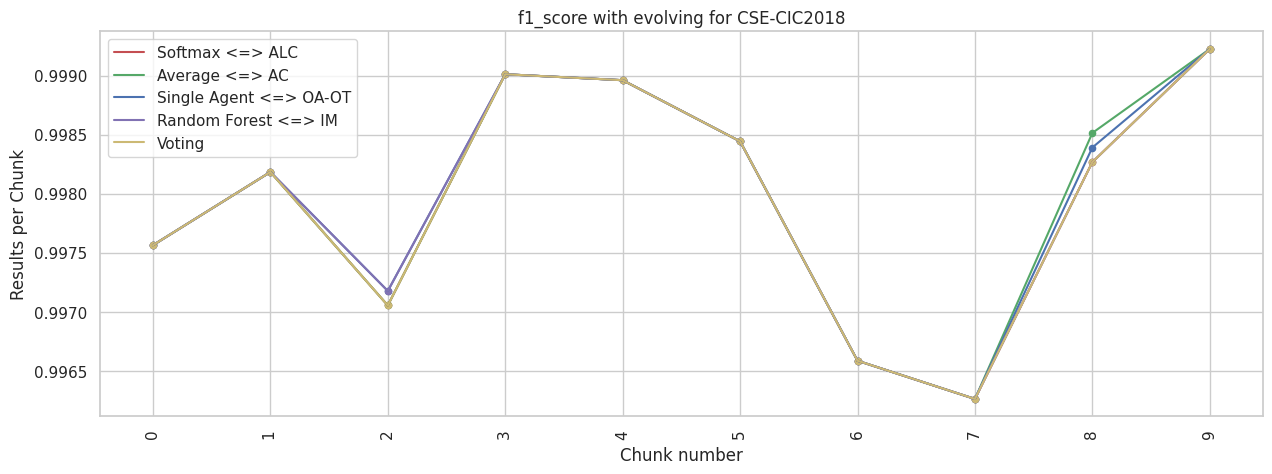

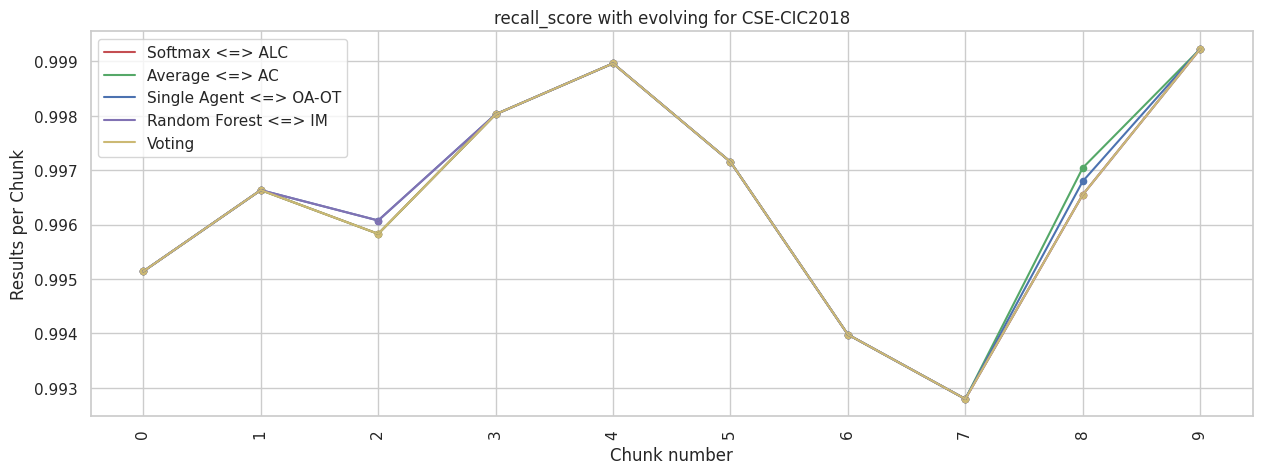

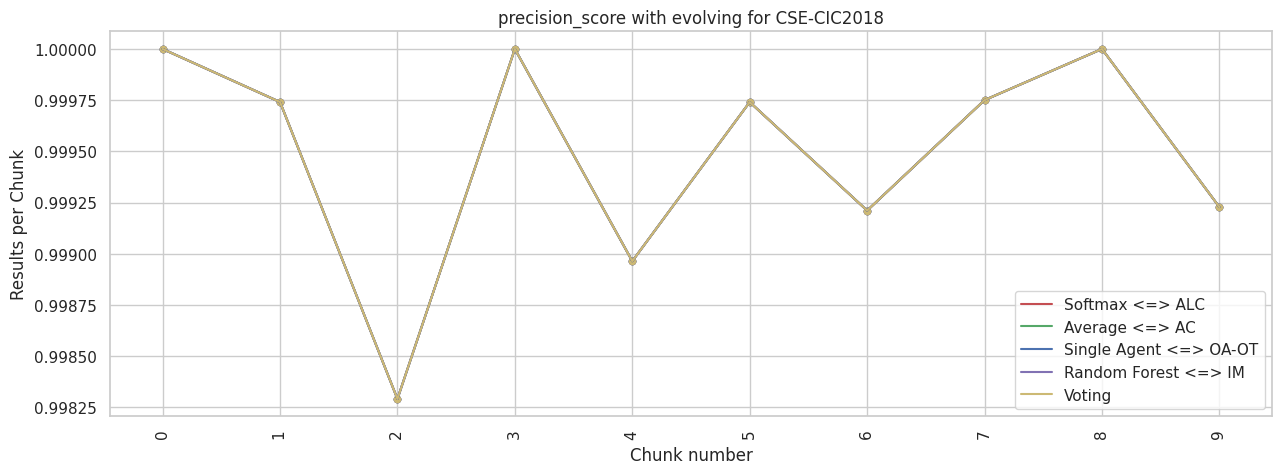

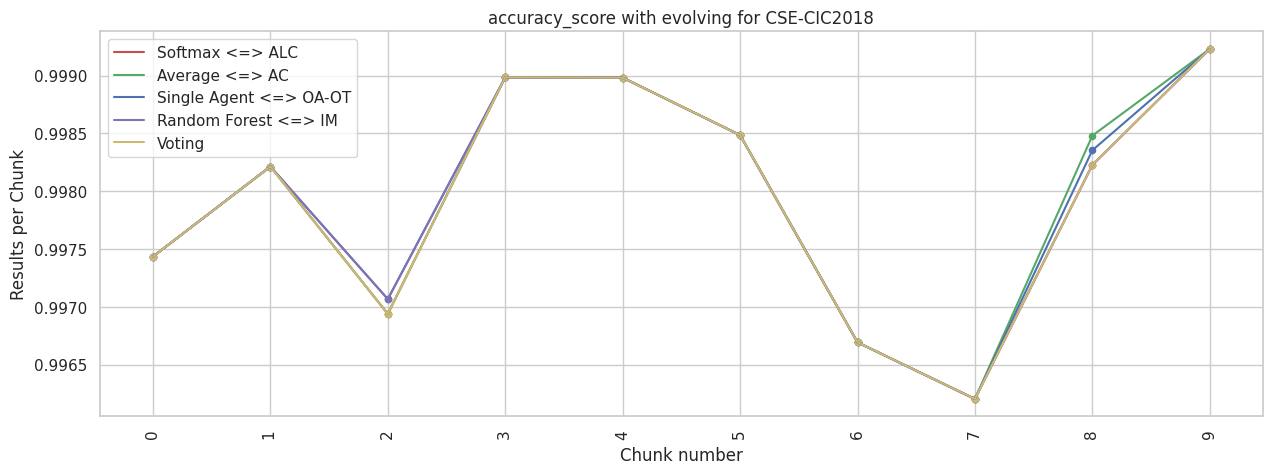

===================== dataset : CICIDS2017 ======================


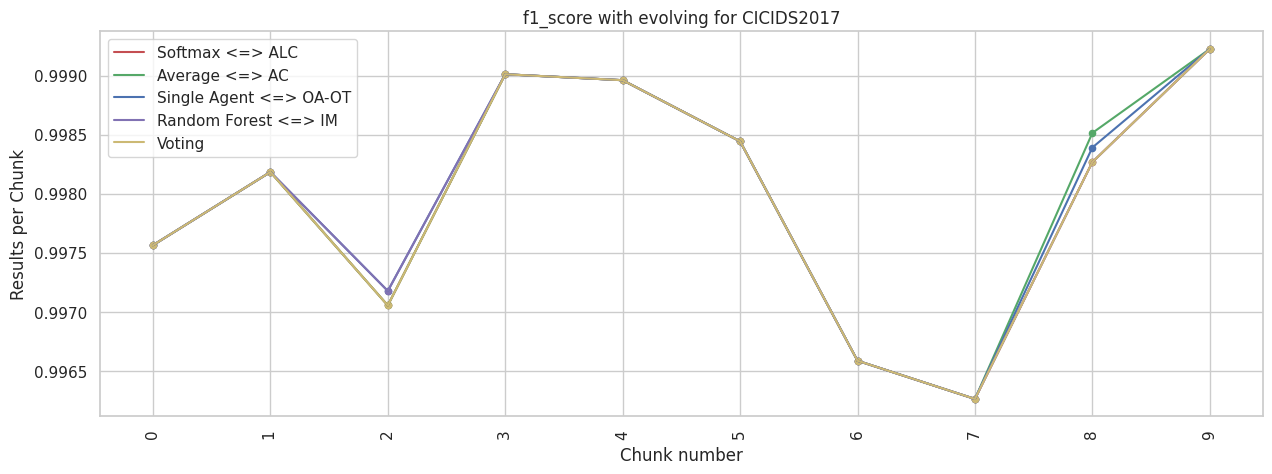

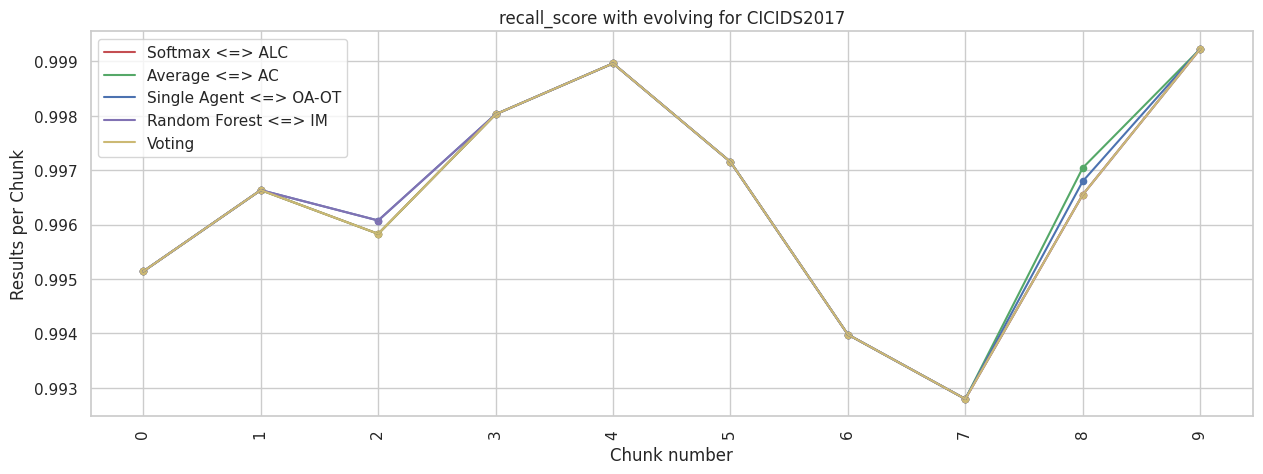

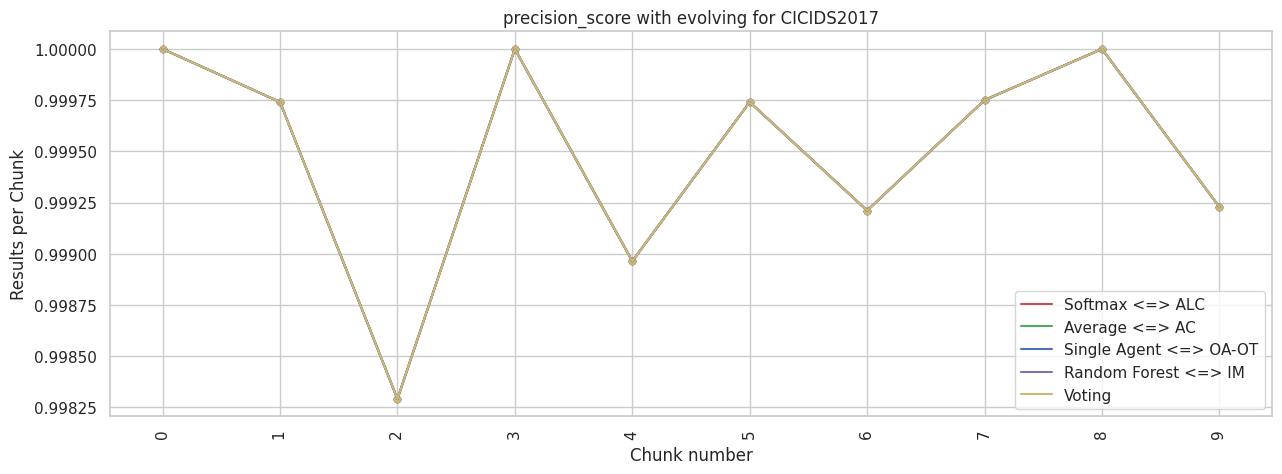

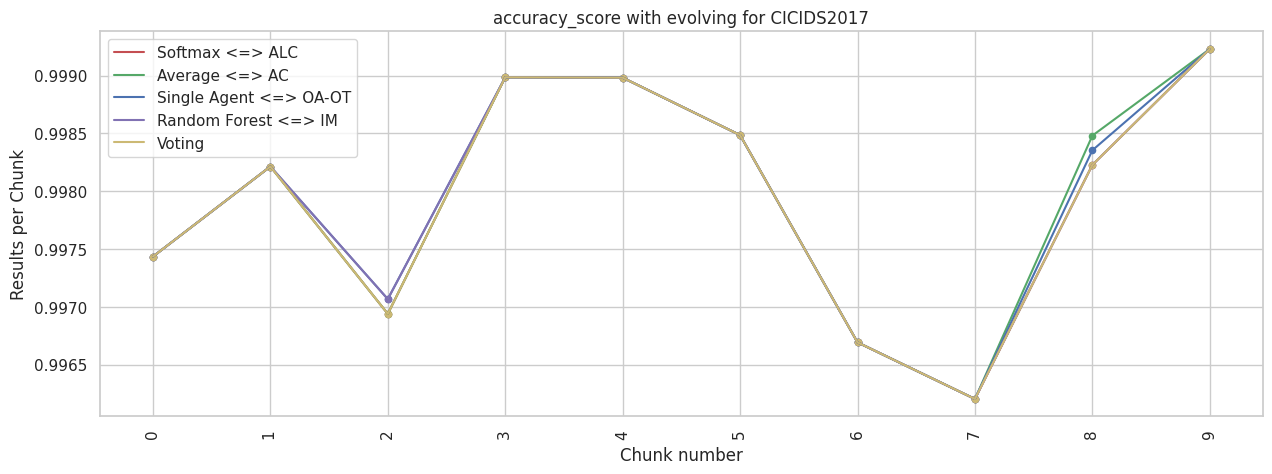

===================== dataset : 7recurrentDrift ======================


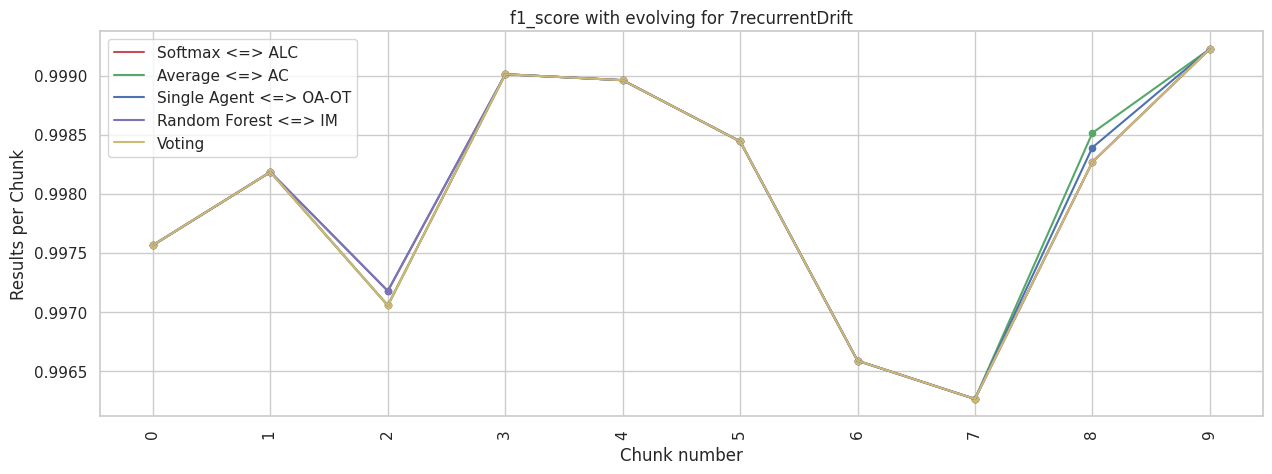

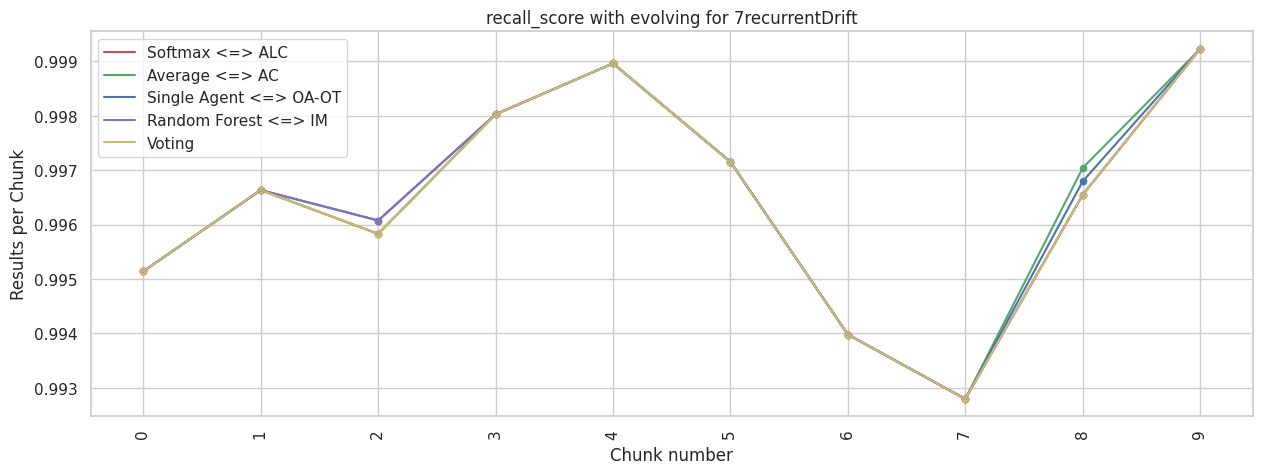

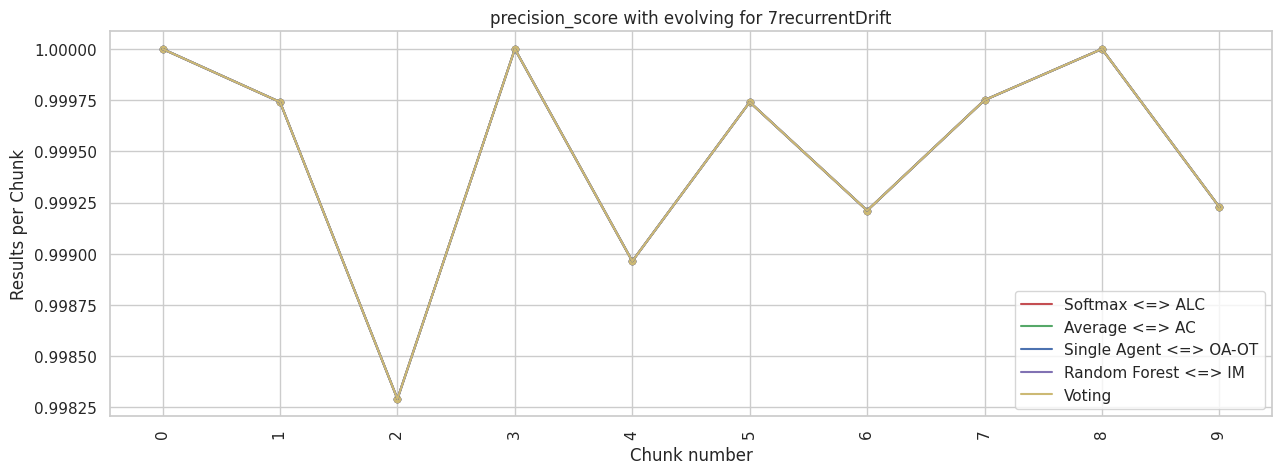

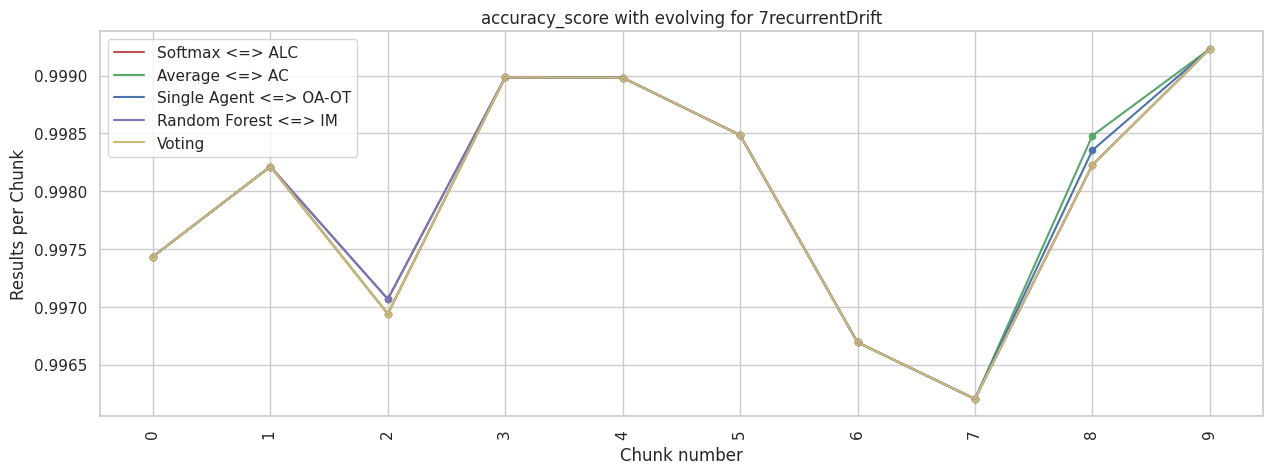

===================== dataset : blip ======================


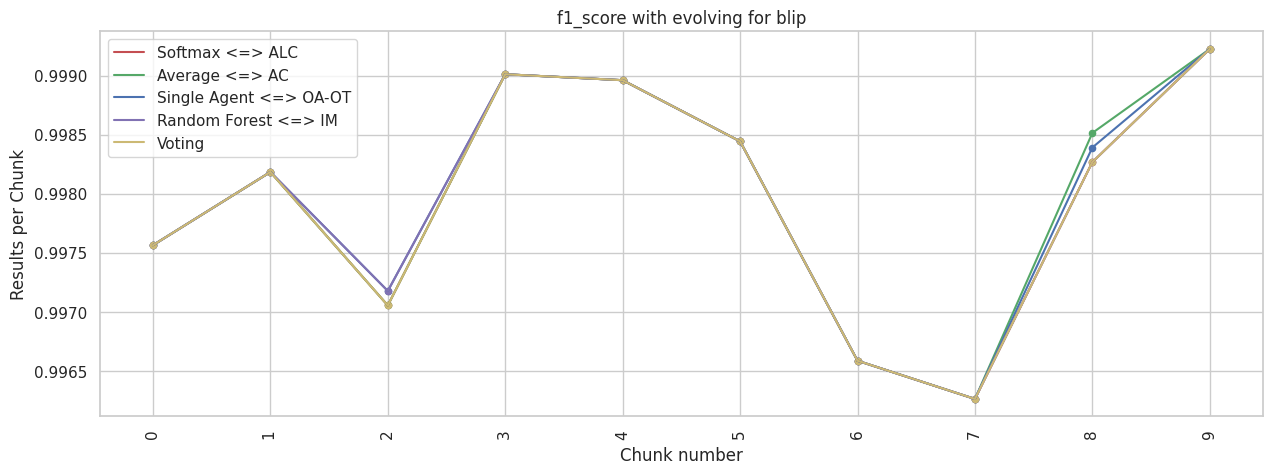

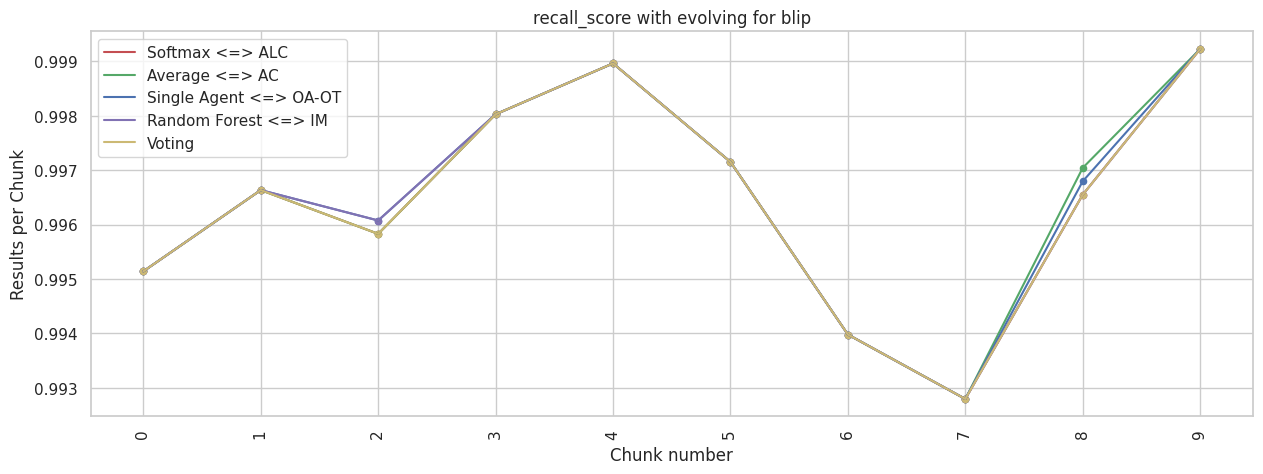

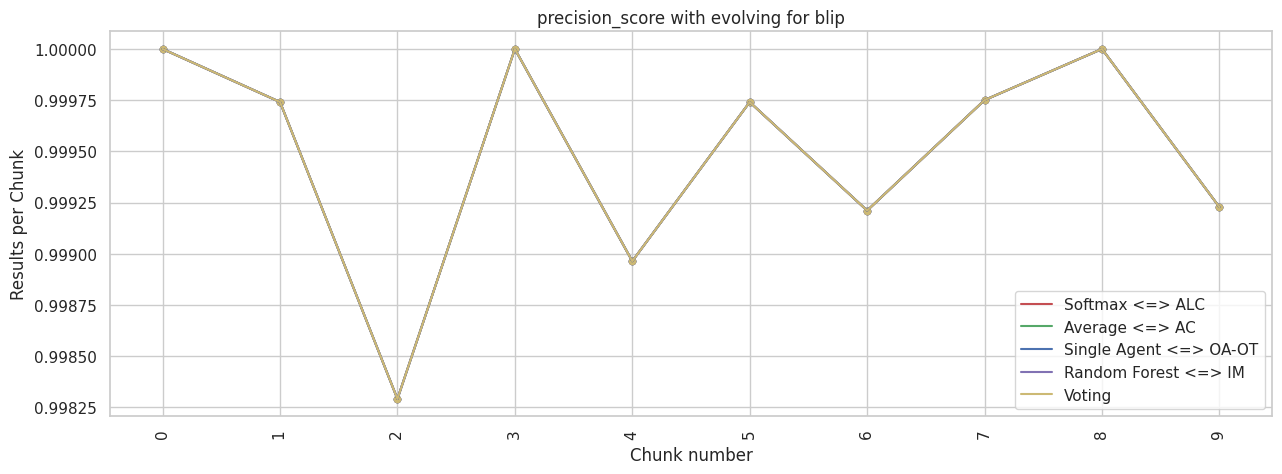

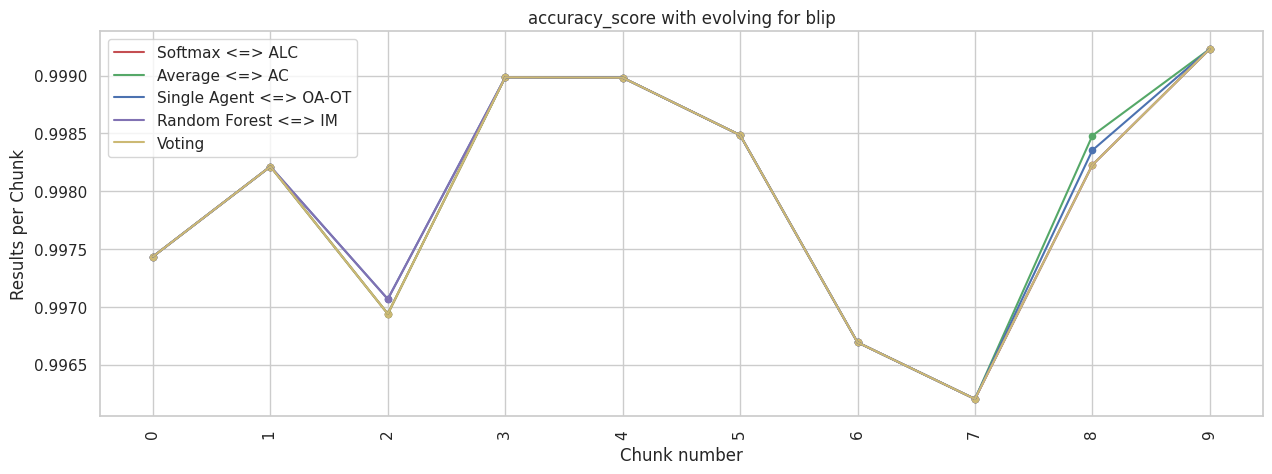

===================== dataset : incrementalDrift ======================


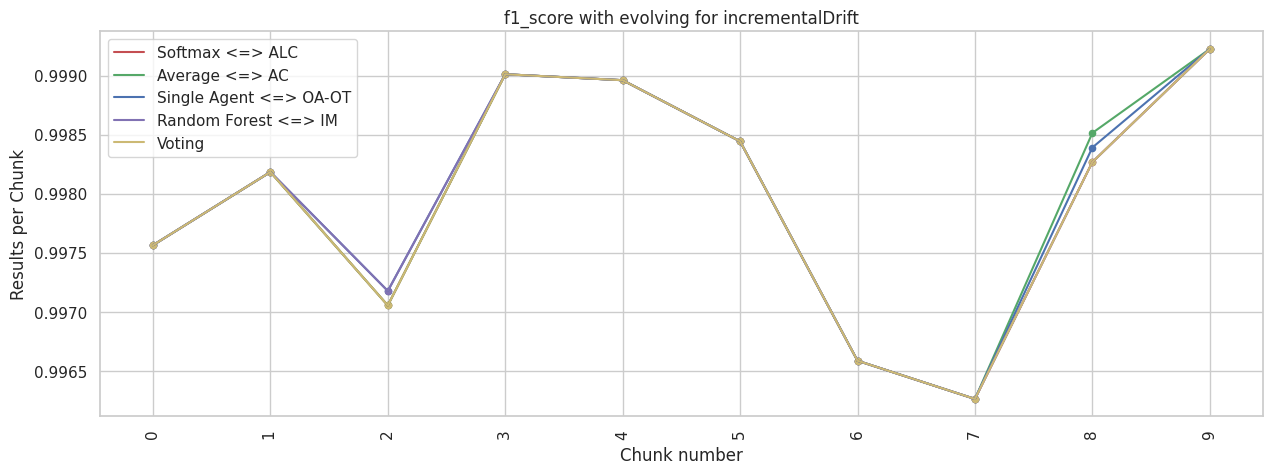

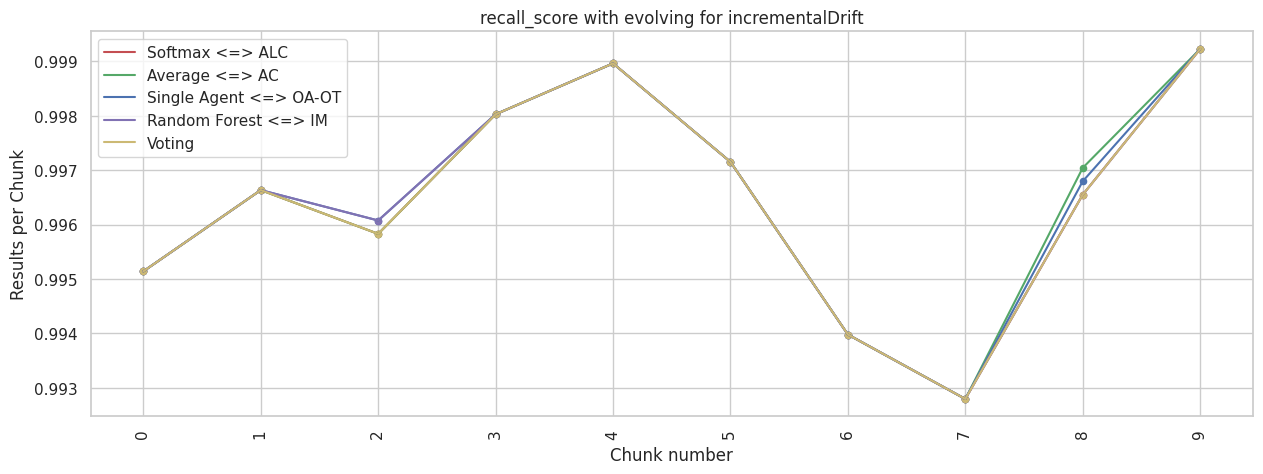

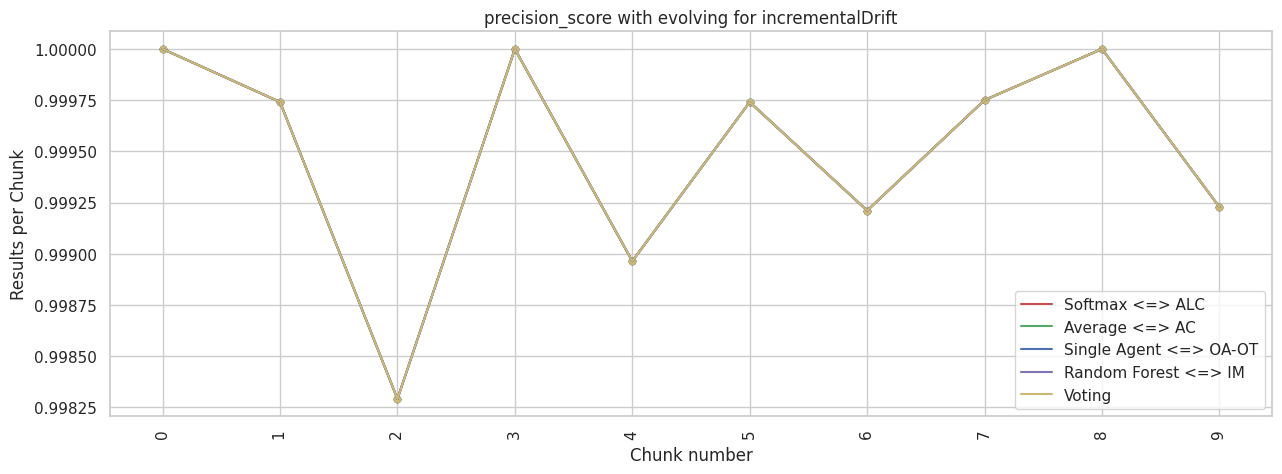

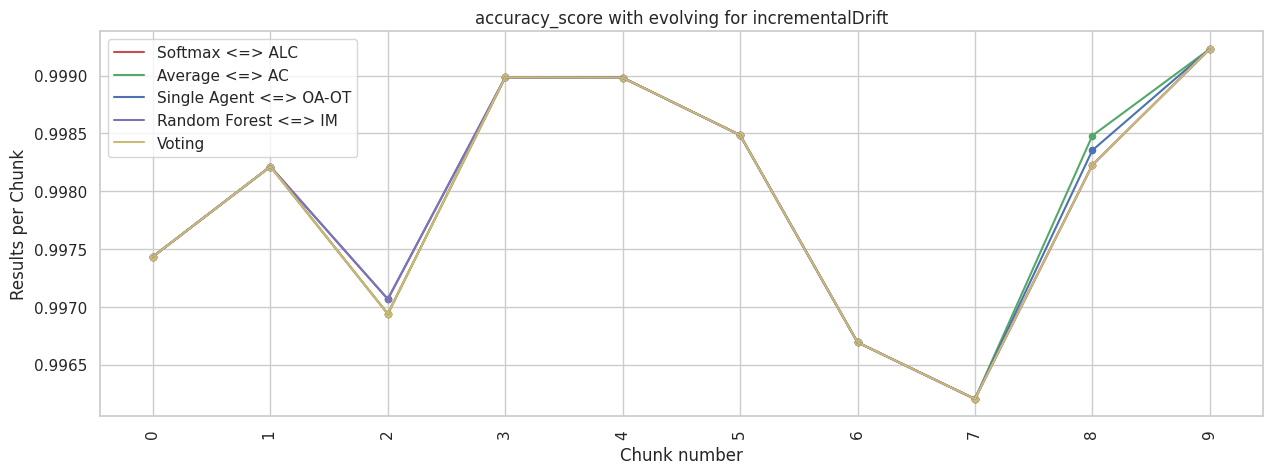

===================== dataset : 7gradualDrift ======================


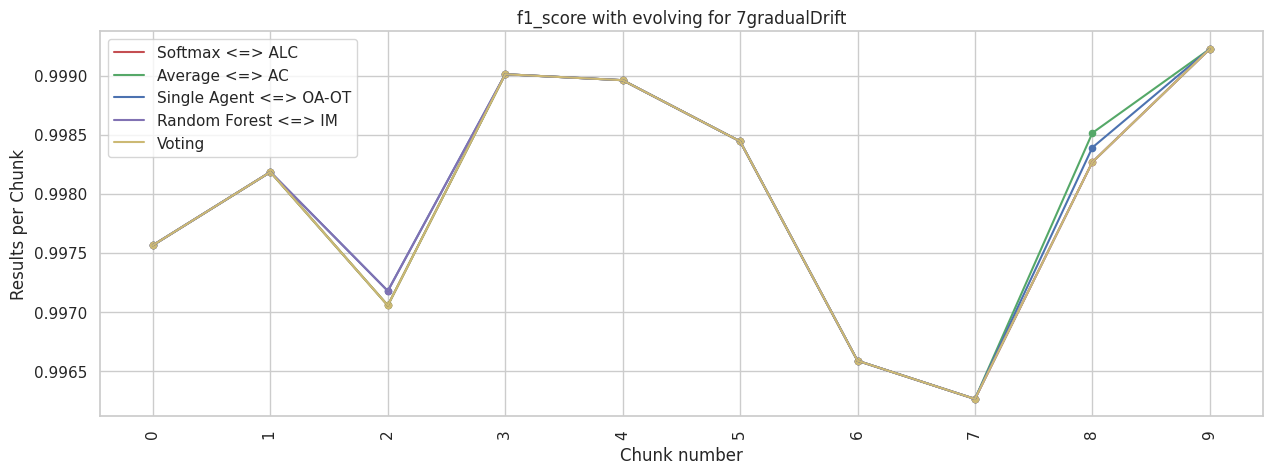

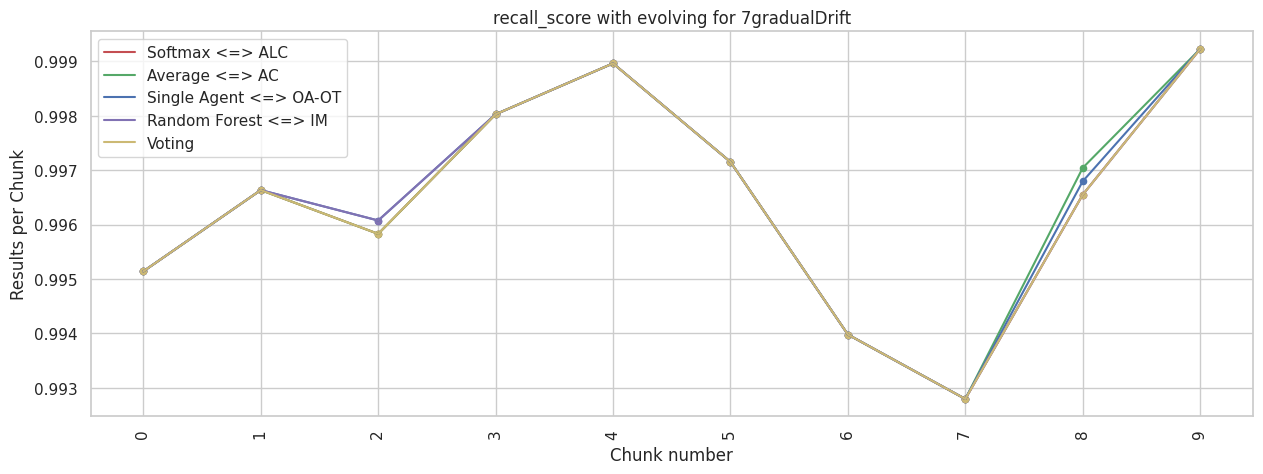

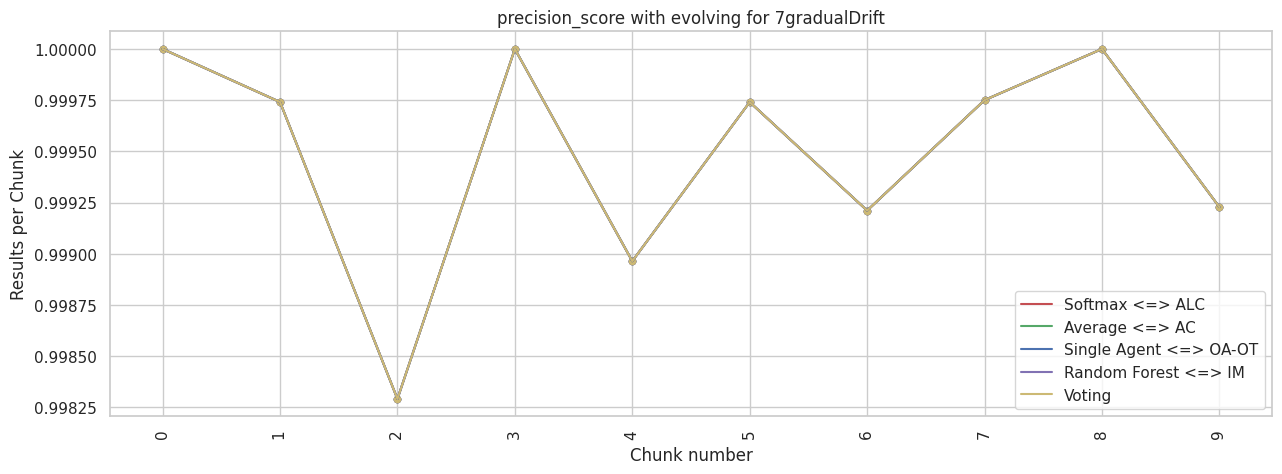

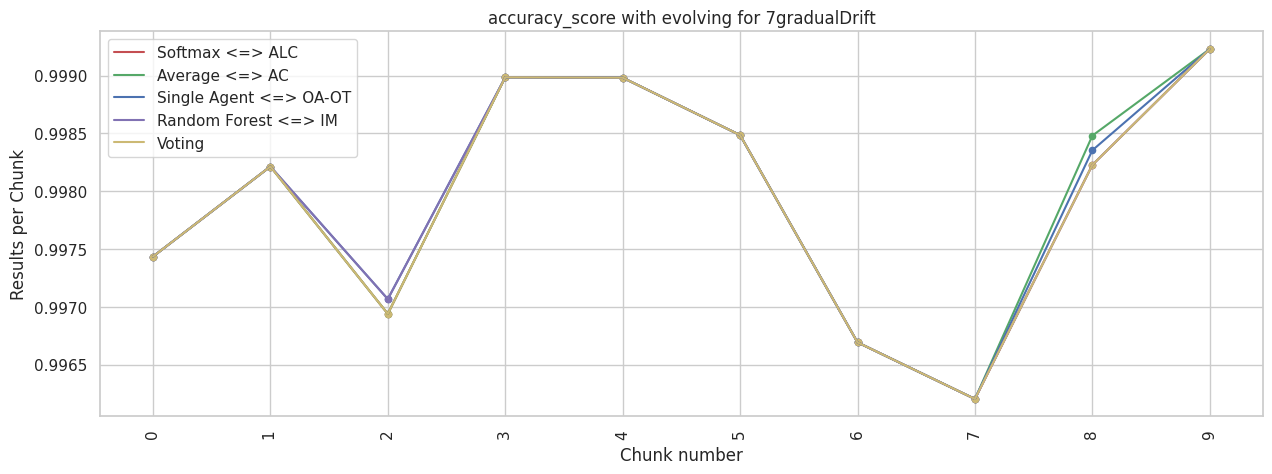

===================== dataset : 7suddenDrift ======================


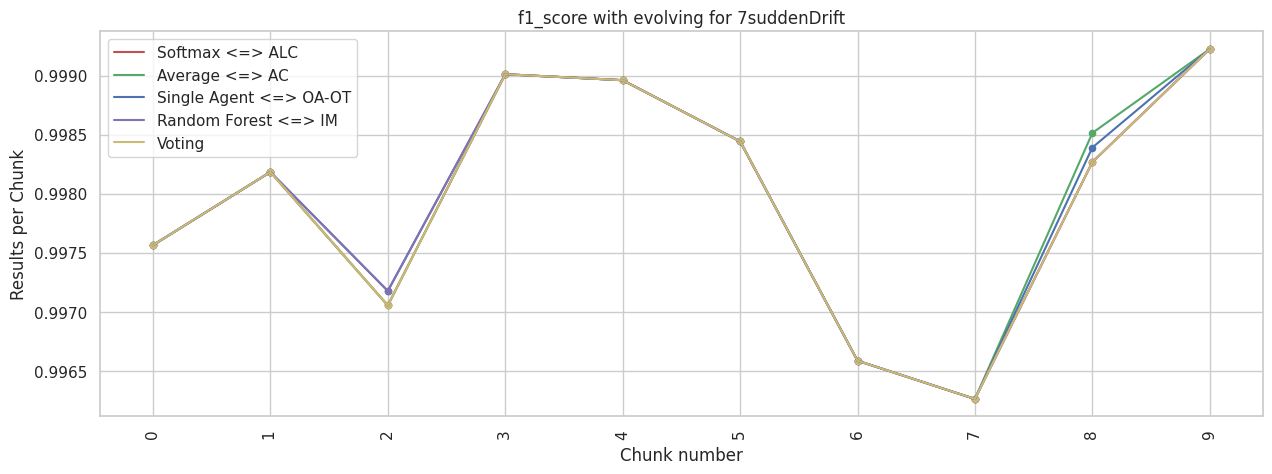

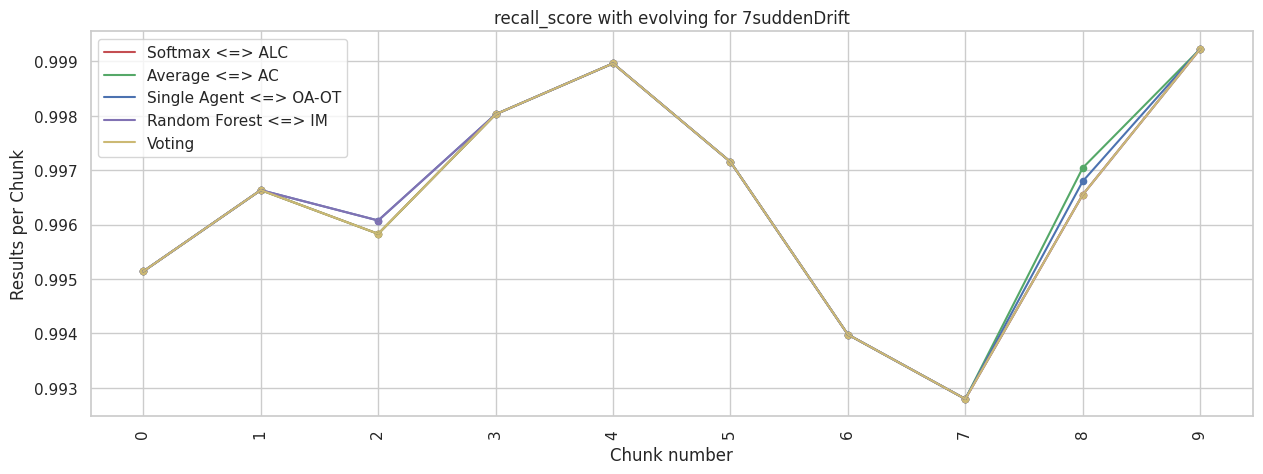

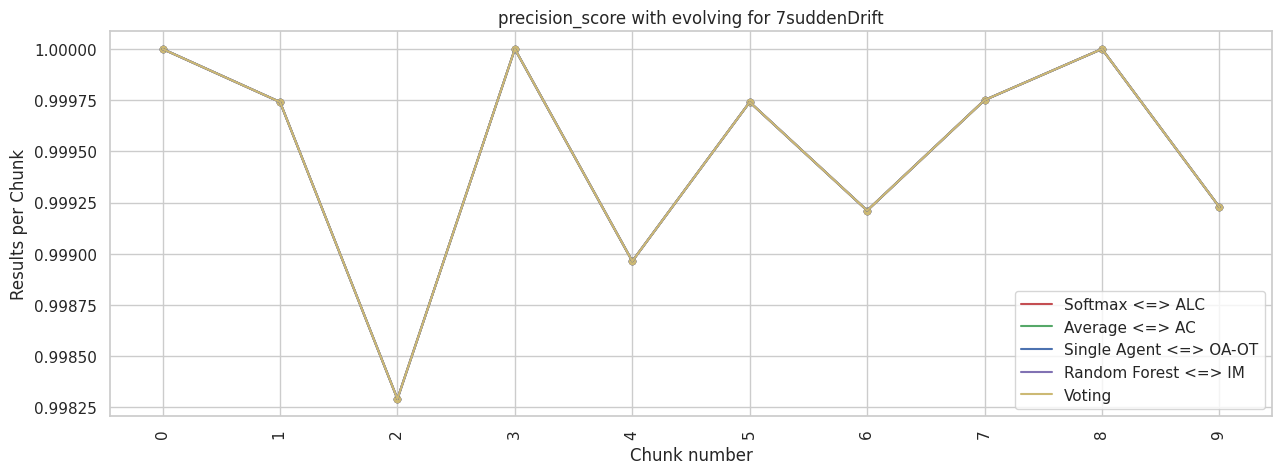

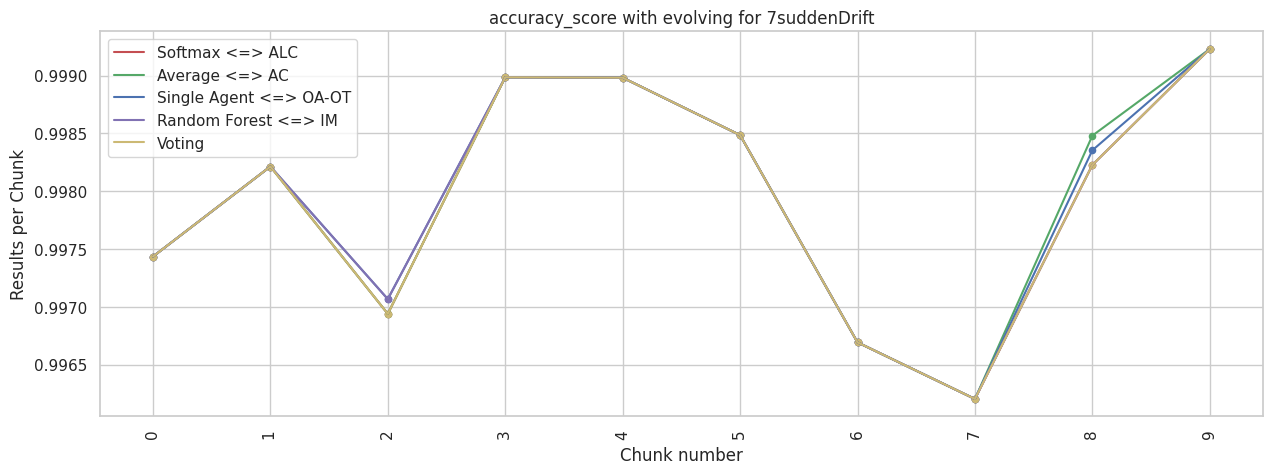

In [12]:
for d_name in data_name:
  load_path = os.path.join(feature_selection_results_evolving,d_name)
  save_path = os.path.join(os.path.join(feature_selection_results_evolving,'Images'),d_name)
  os.makedirs(save_path, exist_ok=True)
  print("===================== dataset : {} ======================".format(d_name))
  for i,metric_name in enumerate(list(softmax_results.keys())[:-1]):
    plot_results(save_path,metric_names[i]+" with evolving"+" for "+d_name, methods_name, [softmax_results[metric_name],average_results[metric_name],single_agent_results[metric_name],random_forest_results[metric_name],voting_results[metric_name]], colors, step=1)